In [108]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

import os

In [109]:
print(os.listdir("dataset"))

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'HAM10000_new_folder']


## Explore data

In [110]:
path = 'dataset'
csv_file='dataset/HAM10000_metadata.csv'

In [111]:
df=pd.read_csv(csv_file).set_index('image_id')
df.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [112]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [113]:
df.dx=df.dx.astype('category',copy=True)
df['labels']=df.dx.cat.codes # Convert the labels to numbers
df['lesion']= df.dx.map(lesion_type_dict)
df.head()

,lesion_id,dx,dx_type,age,sex,localization,labels,lesion
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [114]:
print(df.lesion.value_counts())

lesion
Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='lesion'>

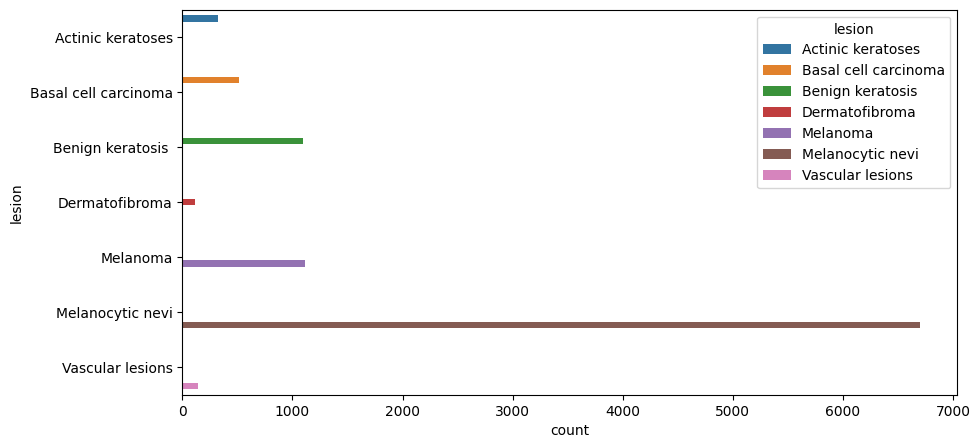

In [115]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

## Dataset

In [116]:
class CustomImageItemList(ImageList):
    def custom_label(self,df, **kwargs)->'LabelList':
        """Custom Labels from path"""
        file_names=np.vectorize(lambda files: str(files).split('/')[-1][:-4])
        get_labels=lambda x: df.loc[x,'lesion']
        #self.items is an np array of PosixPath objects with each image path
        labels= get_labels(file_names(self.items))
        y = CategoryList(items=labels)
        res = self._label_list(x=self,y=y)
        return res

In [117]:
import os
import shutil

# Define source folders
source_folders = ['dataset/HAM10000_images_part_1', 'dataset/HAM10000_images_part_2']

# Define the destination folder
destination_folder = 'dataset/HAM10000_new_folder'  # You can change this to the desired folder name

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate through source folders
for folder in source_folders:
    # Get a list of all files in the source folder
    files = os.listdir(folder)
    
    # Iterate through files
    for file in files:
        # Get the full path of the source file
        source_path = os.path.join(folder, file)
        
        # Check if it's a file (not a directory)
        if os.path.isfile(source_path):
            # Create the destination path
            destination_path = os.path.join(destination_folder, file)
            
            # Copy the file to the destination folder
            shutil.copy(source_path, destination_path)
            print(f'Copied {file} to {destination_folder}')

Copied ISIC_0024306.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024307.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024308.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024309.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024310.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024311.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024312.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024313.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024314.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024315.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024316.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024317.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024318.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024319.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024320.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024321.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024322.jpg to dataset/HAM10000_new_folder
Copied ISIC_0024323.jpg to dataset/HAM10000_new_folder
Copied ISI

In [128]:
def get_data(bs, size):
    train_ds = (CustomImageItemList.from_folder('dataset/HAM10000_new_folder', extensions='.jpg')
                    .split_by_rand_pct(0.15)
                    # .custom_label(df)
                    .transform(tfms=get_transforms(flip_vert=True), size=size)
                    .databunch(num_workers=2, bs=bs)
                    .normalize(imagenet_stats))
    return train_ds

In [129]:
data=get_data(16,224)

AttributeError: 'CustomImageItemList' object has no attribute 'transform'

## ResNet50

In [127]:
learner=create_cnn(data,models.resnet50,metrics=[accuracy], model_dir="/tmp/model/")

NameError: name 'data' is not defined